<h4><i><font color='red'>The project has many components, and we encourage you to complete as many as you can! That said, we highly encourage you to submit your work even if your notebook is only partially completed - the TA can help review your work and provide tips on any places that you got stuck or have further questions!</font></i></h4>

<font size="6">**Table of Contents:**</font>  
<br>
<font size="5">
<u>Approximate Nearest Neighbor Search:</u>  
&emsp;&emsp;1\. [Introduction](#scrollTo=9wDLwRU6HUNG&uniqifier=1)  
&emsp;&emsp;2\. [Setup](#scrollTo=vq47Wt-0Jan-&uniqifier=1)  
&emsp;&emsp;3\. [TODO 3.1: Your KNN](#scrollTo=3u93B8JdJ9pg&uniqifier=1)  
&emsp;&emsp;4\. [Faiss](#scrollTo=TRAg9cqeMiKl&uniqifier=1)  
&emsp;&emsp;5\. [TODO 3.2: KNN Comparison](#scrollTo=-2Xh5R8xT3to&uniqifier=1)  
<br>
<u>User Representations:</u>  
&emsp;&emsp;1\. [Introduction](#scrollTo=Yk2dt4l1VS_A&uniqifier=1)  
&emsp;&emsp;2\. [Setup](#scrollTo=oU7Z49ymW5yO&uniqifier=1)    
&emsp;&emsp;3\. [Initial User and Item Representations](#scrollTo=Frr6CK1NX6dJ&uniqifier=1)    
&emsp;&emsp;4\. [LightGBM as a Ranker](#scrollTo=_FYTNTwUc3ot&uniqifier=1)    
&emsp;&emsp;5\. [TODO 3.3: Your User Representations](#scrollTo=L-ErqwvYd9F7&uniqifier=1)    
&emsp;&emsp;6\. [TODO 3.4: LSTM User Representations (Optional)](#scrollTo=-BxR9VPpjoNi&uniqifier=1)    
</font>

# <u>Approximate Nearest Neighbor Search:</u>

## **1. Introduction**
[back to top](#scrollTo=qfTG6NXWGjQt&uniqifier=1)

In this week's project, we will touch upon two key aspects related to representations:
1. How do we query large amount of vectors in efficient time?
2. How can we infer various user representations and see what their impact is on the downstream task?

Let's begin with the former, which tells us how we could handle a large number of candidate items or user representations in an efficient manner: Approximate Nearest Neighbor (ANN) Search.  
  
<br>Often we are interested in finding nearest neighbors in a large space of vectors. To store embeddings for 400 million users and over 100 million items and querying them in real time is a challenging task. This is where approximate nearest neighbor approaches step in to help. [Annoy](https://github.com/spotify/annoy), [Faiss](https://github.com/facebookresearch/faiss), and [ScaNN](https://github.com/google-research/google-research/tree/master/scann) are typical libraries that are used for efficient vector similarity search at scale. They implement algorithms that search in sets of vectors of any size, up to ones that possibly do not fit in RAM.

In the first part of this week's project, we will simulate embeddings of 500k items and try to find the k-nearest neighbours for an item of interest. We will implement a vanilla search function to fetch the top-k nearest neighbors and estimate the time it takes for us to do so. We will then compare this with Faiss -- Facebook's nearest neighbour search library, and compare the time it takes for us to get nearest neighbours from Faiss versus our own implementation.


## **2. Setup**
[back to top](#scrollTo=qfTG6NXWGjQt&uniqifier=1)

In [1]:
# Installs and imports
!pip install faiss-cpu --no-cache --quiet

import pickle
import faiss
import numpy as np
from IPython.display import clear_output

clear_output()

## **3. TODO 3.1: Your KNN**
[back to top](#scrollTo=qfTG6NXWGjQt&uniqifier=1)

Let's first generate a simulated dataset of embeddings of 500k items each with 64 elements:

In [2]:
# Set seed for reproducibility
np.random.seed(42)

# Generate 500k item vectors with 64 elements
item_vectors = np.random.random((500_000, 64)).astype('float32')

item_vectors.shape

(500000, 64)

Now that we have these items, let's take up the goal of finding the top-k items closest to this specific item. Your goal is to implement your function to estimate the top-k items using [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) to the query item. 
  
Euclidean distance can be [computed*](https://www.google.com/search?q=euclidean+distance&rlz=1C1CHBD_enUS756US756&oq=euclidean+distance&aqs=chrome.0.0i131i433i512l2j0i433i512j0i131i433i512l4j0i512j0i131i433i512l2.2329j1j7&sourceid=chrome&ie=UTF-8#wptab=si:AC1wQDCDyRf_4m8Q8nhldHMjdIalRktweLkw15mQu4pgD74-zUn1N-3MIuKczXZHIoqR9oMGcw61xadKjn9m6kYiyGRz32fPfr5CXMeSXfIndlhRj0dSYnewx44jaNCJZqrvNJZon_B3) as follows:
\begin{align}
\ d(p,q) = \sqrt{\sum_{i=1}^n (p_i-q_i)^2}
\end{align}

p, q = two points in Euclidean n-space  
q<sub>i</sub>, p<sub>i</sub> = Euclidean vectors, starting from the origin of the space (initial point)  
n = n-space  
\* Note that Faiss does not take the final square root.
  
You'll be able to check your work with `index1`, the Faiss Flat Index, below. It should return the same results as your function.

In [26]:
def find_top_k_nn(query_vector, k=5):
    """
    Implement top-k nearest neighbours using Euclidean distance, and return the distances and indices of the these top-k items.
    
    Args:
        query_vector (np.array): Vector representation of the item to retrieve neighbors for.
        k (int): Number of neighbors to retrieve.
        
    Returns:
        distances (list): Distances to top-k nearest neighbors.
        indices (list): Indices of top-k nearest neighbors.
    """
    #distances, indices = [], []
    
    # Reshape query_vector
    query_vector = query_vector.reshape(1,-1)
    # Euclidean distance
    d = np.sqrt(np.square(item_vectors - query_vector).sum(axis=1))
    # Nearest neighbors
    indices = np.argsort(d)[:k]
    distances = d[indices]
    
    return distances, indices

With your top-k NN function implemented, call this function to get the top-k nearest neighbor items for the query_vector and print relevant statistics:

In [27]:
# Helper function to run our KNN functions

def run_knn(knn_function, query_vector, k=5):
    """
    Helper function to run our KNN functions.
    
    Args:
        knn_function (function): Object that returns distances and indices given a query vector.
        query_vector (np.array): Vector representation of the item to retrieve neighbors for.
        k (int): Number of neighbors to retrieve.
    """
    distances, indices = knn_function(query_vector, k=k)
    print(f"Distances from the k nearest neighbors: {distances}")
    print(f"Indices from the k nearest neighbors: {indices}")
    print(f"Average distance of the k nearest neighbors: {np.mean(distances)}")

In [28]:
# We've chosen the query vector for convenience
query_vector = item_vectors[0].reshape(1,-1)

In [29]:
%%time
run_knn(find_top_k_nn, query_vector, k=5)

Distances from the k nearest neighbors: [0.        2.207549  2.22831   2.2385755 2.248366 ]
Indices from the k nearest neighbors: [     0 260846 120114 257179 119384]
Average distance of the k nearest neighbors: 1.784560203552246
CPU times: user 95.6 ms, sys: 24.2 ms, total: 120 ms
Wall time: 117 ms


## **4. Faiss**
[back to top](#scrollTo=qfTG6NXWGjQt&uniqifier=1)

Now we'll switch to using [Faiss](https://github.com/facebookresearch/faiss) for our KNN.  
  
<br>Given a set of vectors x<sub>i</sub> in dimension d, Faiss builds a data structure in RAM. After the structure is constructed, when given a new vector x in dimension d, it efficiently performs:

i = argmin<sub>i</sub> ||x - x<sub>i</sub>||

where ||.|| is the Euclidean distance (L2).

If Faiss terms, the data structure is an index, an object that has an add method to add x<sub>i</sub> vectors. Note that the x<sub>i</sub>'s are assumed to be fixed. Computing the argmin is the search operation on the index.  
  
<br>

### Indexes used by Faiss

1. The inverted file from [Video google: A text retrieval approach to object matching in videos](https://www.robots.ox.ac.uk/~vgg/publications/papers/sivic03.pdf). This is the key to non-exhaustive search in large datasets. Otherwise all searches would need to scan all elements in the index, which is prohibitive even with a fast operation.


2. The product quantization (PQ) method from [Product quantization for nearest neighbor search](https://lear.inrialpes.fr/pubs/2011/JDS11/jegou_searching_with_quantization.pdf). This can be seen as a lossy compression technique for high-dimensional vectors that allows relatively accurate reconstructions and distance computations in the compressed domain.


3. The three-level quantization (IVFADC-R aka IndexIVFPQR) method from [Searching in one billion vectors: re-rank with source coding](https://arxiv.org/pdf/1102.3828.pdf).


We will use these three indexes from Faiss to search our vectors to get the top-k nearest neighbours and estimate the average distance:

In [30]:
%%time

# Build flat index
# Docs: https://faiss.ai/cpp_api/struct/structfaiss_1_1IndexFlatL2.html
index1 = faiss.IndexFlatL2(item_vectors.shape[1])

# Add vectors
index1.add(item_vectors)

print(f"Total number of vectors indexed: {index1.ntotal:,}")

Total number of vectors indexed: 500,000
CPU times: user 12 ms, sys: 27.9 ms, total: 39.9 ms
Wall time: 39.6 ms


In [31]:
%%time

# Build quantizer
quantizer = faiss.IndexFlatL2(item_vectors.shape[1])

# Build inverted index
# Docs: https://faiss.ai/cpp_api/struct/structfaiss_1_1IndexIVFFlat.html
nlist = 100 # number of possible key values
index2 = faiss.IndexIVFFlat(quantizer, item_vectors.shape[1], nlist, faiss.METRIC_L2)

# Train index and add vectors
index2.train(item_vectors)
index2.add(item_vectors)

print(f"Total number of vectors indexed: {index2.ntotal:,} ")

Total number of vectors indexed: 500,000 
CPU times: user 279 ms, sys: 77.4 ms, total: 356 ms
Wall time: 227 ms


In [32]:
%%time

# Build quantizer
quantizer = faiss.IndexFlatL2(item_vectors.shape[1])

# Build product quantized index
# Docs: https://faiss.ai/cpp_api/struct/structfaiss_1_1IndexIVFPQ.html
nlist = 100
m = 8 # max number of codes to visit to do a query
num_bits = 8 # number of bits per index
index3 = faiss.IndexIVFPQ(quantizer, item_vectors.shape[1], 
                          nlist, m, num_bits)

# Train index and add vectors
index3.train(item_vectors)
index3.add(item_vectors)

print(f"Total number of vectors indexed: {index3.ntotal:,} ")

Total number of vectors indexed: 500,000 
CPU times: user 6.94 s, sys: 311 ms, total: 7.25 s
Wall time: 3.62 s


Now that we have these three indexes, let us query these to fetch the top-k nearest neghbours for our query_vector and compute the average distance we obtain for each.

Now we'll use and time these indexes to find the top-k nearest neighbours to highlight the trade-off between accuracy and latency:

In [33]:
%%time
run_knn(index1.search, query_vector, k=5)

Distances from the k nearest neighbors: [[0.        4.873273  4.9653664 5.01122   5.055151 ]]
Indices from the k nearest neighbors: [[     0 260846 120114 257179 119384]]
Average distance of the k nearest neighbors: 3.98100209236145
CPU times: user 17.1 ms, sys: 4.99 ms, total: 22 ms
Wall time: 19.2 ms


In [34]:
%%time
run_knn(index2.search, query_vector, k=5)

Distances from the k nearest neighbors: [[0.        5.055151  5.3904743 5.531457  5.603972 ]]
Indices from the k nearest neighbors: [[     0 119384  38201 409057  27690]]
Average distance of the k nearest neighbors: 4.316210746765137
CPU times: user 1.23 ms, sys: 1.33 ms, total: 2.56 ms
Wall time: 1.36 ms


In [35]:
%%time
run_knn(index3.search, query_vector, k=5)

Distances from the k nearest neighbors: [[1.638771  5.340219  5.429793  5.4401317 5.490528 ]]
Indices from the k nearest neighbors: [[     0 409057  72742  27690  38201]]
Average distance of the k nearest neighbors: 4.667888641357422
CPU times: user 1.02 ms, sys: 896 µs, total: 1.92 ms
Wall time: 969 µs


As expected, we observe that the product quantization and inverted based indexes are an order of magnitude faster than the flat index while the average distance is larger. In terms of accuracy, if we assume that the lower the distance the more accurate the result, the Flat Index gives us the most accurate result but is relatively slow.

## **5. TODO 3.2: KNN Comparison**
[back to top](#scrollTo=qfTG6NXWGjQt&uniqifier=1)

Your second goal in this section is to compare your KNN to the 3 Faiss indexes we created above: Compare the average distance obtained and the time it took to query the 500k vectors. A nice 2D plot would also give you a good idea of the latency-accuracy trade-off involved.

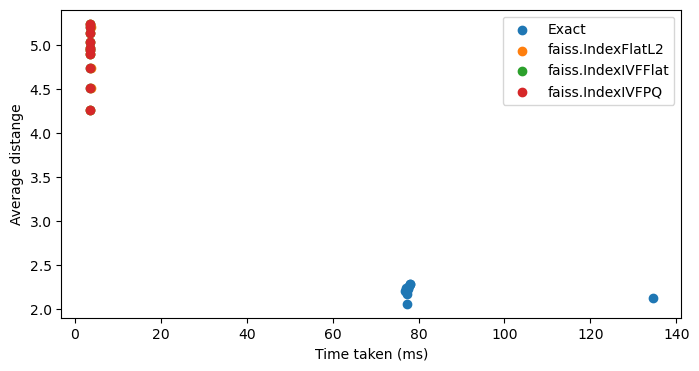

In [57]:
import matplotlib.pyplot as plt
import time

n_trials = 10

# Distance arrays
exact_dis = []
faiss1_dis = []
faiss2_dis = []
faiss3_dis = []

# Time taken arrays
exact_time = []
faiss1_time = []
faiss2_time = []
faiss3_time = []

for n in range(n_trials):
    query_idx = np.random.choice(range(item_vectors.shape[0]), 1)[0]
    query_vector = item_vectors[query_idx].reshape(1,-1)
    
    # Exact
    start = time.time()
    dis, _ =  find_top_k_nn(query_vector, k=5)
    end = time.time()
    exact_dis.append(np.mean(dis[1:])) # Drop distance to itself from average
    exact_time.append((end - start) * 1000)
    
    # Faiss1
    start = time.time()
    dis, _ = index1.search(query_vector, k=5)
    end = time.time()
    dis = dis.flatten()
    faiss1_dis.append(np.mean(dis[1:]))
    faiss1_time.append((end - start) * 1000)
    
    # Faiss2
    start = time.time()
    dis, _ = index1.search(query_vector, k=5)
    end = time.time()
    dis = dis.flatten()
    faiss2_dis.append(np.mean(dis[1:]))
    faiss2_time.append((end - start) * 1000)

    # Faiss3
    start = time.time()
    dis, _ = index1.search(query_vector, k=5)
    end = time.time()
    dis = dis.flatten()
    faiss3_dis.append(np.mean(dis[1:]))
    faiss3_time.append((end - start) * 1000)
    
f, ax = plt.subplots(figsize=(8,4))
ax.scatter(exact_time, exact_dis, label='Exact')
ax.scatter(faiss1_time, faiss1_dis, label='faiss.IndexFlatL2')
ax.scatter(faiss2_time, faiss2_dis, label='faiss.IndexIVFFlat')
ax.scatter(faiss3_time, faiss3_dis, label='faiss.IndexIVFPQ')
plt.xlabel('Time taken (ms)')
plt.ylabel('Average distange')
plt.legend()
plt.show()

# <u>User Representations:</u>

## **1. Introduction**
[back to top](#scrollTo=qfTG6NXWGjQt&uniqifier=1)

In the second part of this week's project, we'll establish a few ways of estimating user representations and understand how each impacts the performance of a ranker.  
  
<br>More broadly, we will:
* Fix the article representations
* Fix the downstream task (ranking)
* Vary the user representations 
* Measure changes in performance in terms of MRR
  
<br>**This section benefits from using a GPU!**  
You can use it for free, in Google Colab, by going to the menu bar above, selecting `Runtime`, then `Change runtime type`, then selecting `GPU` as the `Hardware accelerator`.

## **2. Setup**
[back to top](#scrollTo=qfTG6NXWGjQt&uniqifier=1)

In [1]:
# Installs and imports

# Install LightGBM with GPU support
#!pip uninstall lightgbm --y
#!pip install lightgbm --install-option=--gpu
# **** 
# Had issues install lightgbm on my mac with m1. Had to install it with conda 
# ******

import numpy as np
import pandas as pd
import random
import gc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb
from datetime import timedelta
from tqdm import tqdm
import h5py
import os
import shutil
from collections import defaultdict
from IPython.display import clear_output

clear_output()

In [2]:
# Download data
!pip install -U --no-cache-dir gdown --pre
!gdown --no-cookies --folder https://drive.google.com/drive/folders/1j9QpkSKwqFfpgohbVxdPDKuwmwJXZ6yz?usp=sharing

clear_output()

Assemble train and test sets as we've done in previous notebooks:

In [3]:
# Read in data into memory with some explicit datatypes so they're easier to work with

tran_dtypes = {"t_dat":"str",
               "customer_id":"str",
               "article_id":"int",
               "product_code":"int",
               "price":"float",
               "sales_channel_id":"int"}
art_dtypes = {"article_id":"int",
              "product_code":"int",
              "product_type_no":"int",
              "graphical_appearance_no":"int",
              "colour_group_code":"int",
              "department_no":"int",
              "index_code":"str",
              "index_group_no":"int",
              "section_no":"int",
              "garment_group_no":"int"}
cust_dtypes = {"customer_id":"str"}

article_df = pd.read_csv("hmdata/articles.csv.zip", dtype=art_dtypes)
customer_df = pd.read_csv("hmdata/customers.csv.zip", dtype=cust_dtypes)
transaction_df = pd.read_csv('hmdata/transactions_train.csv.zip', dtype=tran_dtypes)

In [4]:
# Create train and test sets

N_DAYS_TRAIN = 45
N_DAYS_TEST = 7

max_date = transaction_df['t_dat'].max()
train = transaction_df[(transaction_df['t_dat']>=((pd.to_datetime(max_date) - timedelta(days=N_DAYS_TRAIN+N_DAYS_TEST)).date().strftime('%Y-%m-%d')))
                       & (transaction_df['t_dat']<((pd.to_datetime(max_date) - timedelta(days=N_DAYS_TEST)).date().strftime('%Y-%m-%d')))]
test = transaction_df[(transaction_df['t_dat']>=((pd.to_datetime(max_date) - timedelta(days=N_DAYS_TEST)).date().strftime('%Y-%m-%d')))]

# Delete transaction_df from the namespace to free up some memory
transaction_df = None
del transaction_df
gc.collect()

122

In [5]:
# Remove users from test that are not in train to remove cold-start scenarios
test = test[test['customer_id'].isin(train['customer_id'].unique())]

# Make distinction between train and test articles since we'll be creating article representations using the training set
train_article_df = article_df[article_df['article_id'].isin(train['article_id'].unique())].copy()
test_article_df = article_df[~article_df['article_id'].isin(train['article_id'].unique())].copy()

# Free up memory again
gc.collect()

0

In [6]:
# Generate N negative samples per row (user-article transaction)

def generate_negative_samples(df, article_list, num_neg=1, negative_sample_multiplier=20):
    """
    Generates `num_neg` negative samples from `article_list` per row (customer_id, article_id interaction) in `df`.

    Args:
        df (DataFrame): Positive transactions between customers and articles. Expects features `customer_id` and `article_id`.
        article_list (list): Article IDs for negative sampling.
        num_neg (int): Number of negative samples to generate per row.
        negative_sample_multiplier (int): Multiplier that allows us to randomly sample negative candidates all at once.
            Necessary to be larger than 1 in most cases since we will filter out some candidates.

    Raises:
        Warning in case we did not generate the intended number of negative samples per row.

    Returns:
        negative_df (DataFrame): Original, positive samples concatenated with generated, negative samples.
    """
    # Create lookup of positive samples. We don't want to include negative samples that are actually positives
    customer2positives = dict(df.groupby('customer_id')['article_id'].apply(lambda x: x.values))
    customer2positives = {k:set(v) for k,v in customer2positives.items()}

    # Sample random negatives all at once
    np.random.seed(42)
    random_sample_size = (len(df), num_neg*negative_sample_multiplier)
    random_samples = np.random.choice(article_list, 
                                      size=random_sample_size,
                                      replace=True)
    
    # Generate negative samples
    customers, articles, labels = [], [], []
    for n, (customer_id, article_id) in enumerate(tqdm(zip(df['customer_id'], df['article_id']), total=len(df), 
                                                       leave=True, position=0)):
        customers.append(customer_id)
        articles.append(article_id)
        labels.append(1)
        count, temp_negatives = 0, set()
        for negative_id in random_samples[n]:
            if (negative_id not in customer2positives[customer_id]) \
                & (negative_id not in temp_negatives):
                customers.append(customer_id)
                articles.append(negative_id)
                labels.append(0)
                temp_negatives.add(negative_id)
                count += 1
            if count == num_neg:
                break

    # Create result dataframe of positives and negatives, and data quality check
    negative_df = pd.DataFrame({'customer_id':customers, 'article_id':articles, 'label':labels})
    if len(negative_df) != (len(df)*num_neg+len(df)):
        print('WARNING: Not enough samples generated. Increase `negative_sample_multiplier`.')
    return negative_df


# Note: We only generate negative samples from the training set to avoid leakage
articles_set = list(train.article_id.unique())
train_negative = generate_negative_samples(train, articles_set, num_neg=2)
test_negative = generate_negative_samples(test, articles_set, num_neg=2)

train_negative.shape, test_negative.shape

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149631/149631 [00:00<00:00, 1205518.79it/s]


((5307291, 3), (448893, 3))

## **3. Initial User and Item Representations**
[back to top](#scrollTo=qfTG6NXWGjQt&uniqifier=1)

We'll start by extracting our fixed article representations by taking the raw categorical features and concatenating them with TF-IDF  representations of article descriptions. We then process them with SVD. In total TF-IDF followed by SVD is a technique known as [Latent Semantic Indexing (LSI)](https://radimrehurek.com/gensim/models/lsimodel.html).

In [7]:
%%time

def train_article_representations():
    """
    Trains article representations for both the train and test sets. 
    
    Args:
        None.
        
    Returns:
        article2vec (dict): Article ID to vector representation lookup.
        
    """
    # Find categorical columns
    ohe_columns = []
    for col in train_article_df.columns:
        if train_article_df[col].dtype == "int64" and len(train_article_df[col].unique()) <= 500:
            ohe_columns.append(col)

    # Get ohe article features
    # Make sure test only has values included in train, and the order of the encodings is the same
    train_ohe_vectors = pd.get_dummies(train_article_df[ohe_columns], columns=ohe_columns)
    test_ohe_vectors = pd.get_dummies(test_article_df[ohe_columns], columns=ohe_columns)
    for col in train_ohe_vectors.columns:
        if col not in test_ohe_vectors.columns:
            test_ohe_vectors[col] = 0
    test_ohe_vectors = test_ohe_vectors[train_ohe_vectors.columns].values
    train_ohe_vectors = train_ohe_vectors.values

    # Get tf-idf article features
    tfidf = TfidfVectorizer(min_df=3)
    train_tfidf_vectors = tfidf.fit_transform(train_article_df["detail_desc"].fillna("nodesc"))
    test_tfidf_vectors = tfidf.transform(test_article_df["detail_desc"].fillna("nodesc"))

    # Represent articles as 200 element vectors using concatenated ohe and tf-idf features
    svd = TruncatedSVD(n_components=200, random_state=42)
    train_article_vectors = np.hstack([train_ohe_vectors, 
                                       np.asarray(train_tfidf_vectors.todense())])
    train_article_vectors = svd.fit_transform(train_article_vectors)
    test_article_vectors = np.hstack([test_ohe_vectors, 
                                      np.asarray(test_tfidf_vectors.todense())])
    test_article_vectors = svd.transform(test_article_vectors)
    
    # Create article to vector lookup
    article2vec = dict(zip(train_article_df['article_id'], train_article_vectors))
    article2vec.update(dict(zip(test_article_df['article_id'], test_article_vectors)))
    
    return article2vec


article2vec = train_article_representations()

CPU times: user 53 s, sys: 2.92 s, total: 55.9 s
Wall time: 9.24 s


Next we'll write the first function to create user representations as a set of raw features:

In [8]:
def user_representation_1():
    """
    First function to generate user representations: Raw user features.
    
    Args:
        None.
        
    Returns:
        user2vec (dictionary): Customer to vector representations lookup.
    """
    df_cust = customer_df.copy()
    df_cust["age"] = df_cust["age"].fillna(df_cust["age"].mean())
    df_cust[["FN","Active"]] = df_cust[["FN","Active"]].fillna(0)
    df_cust["club_member_status"] = df_cust["club_member_status"].apply(lambda x:1 if x == "ACTIVE" else 0)
    df_cust["fashion_news_frequency"] = df_cust["fashion_news_frequency"].apply(lambda x:0 if x == "NONE" else 1)
    df_cust = df_cust[["customer_id","age","FN","Active","club_member_status","fashion_news_frequency"]]
    user2vec = df_cust.set_index('customer_id').apply(lambda x: x.values, axis=1).to_dict()
    return user2vec

Now we have all the ingredients we need: A basic version of user representations, article representations, and transactions data on which we can train our downstream task. We'll consider the task of predicting whether or not a user will purchase an article as we've been doing the past 2 weeks.

## **4. LightGBM as a Ranker**
[back to top](#scrollTo=qfTG6NXWGjQt&uniqifier=1)

While we have used neural models so far, let's try a tree-based model, [LightGBM](https://lightgbm.readthedocs.io/en/v3.3.2/), for this task. Note that, due to Colab's compute constraints, it would normally be difficult to train a model with the amount of data we currently have. We've leveraged [h5py](https://docs.h5py.org/en/latest/quick.html) files, which allow for storing data on disk as opposed to in memory, so that we can train on data that is too large to fit in memory!

In [9]:
# Model parameters

random_seed = 42

lgb_params = {
    "objective": "binary",
    "num_trees":300,
    "max_leaves":300,
    "bagging_seed": random_seed,
    "random_state": random_seed,
    "verbose": 1,
    "device": "cpu"  # GPU didn't work on m1 mac. Changed to CPU
}

In [10]:
# Train and evaluate LightGBM model

def calculate_test_mrr(predictions):
    """
    Calculates and prints Mean Reciprocal Rank (MRR) on the test set.
    
    Args:
        predictions (np.array): Model predictions.
        
    Returns:
        None
    """
    dataframe = test_negative.copy()
    dataframe['prediction_score'] = predictions
    dataframe.sort_values(by=['customer_id', 'prediction_score'], ascending=False, inplace=True)
    reciprocal_rank = dataframe.groupby('customer_id').apply(lambda x: 1/(np.where(x['label']==1)[0][0]+1)) 
    dataframe.drop('prediction_score', axis=1, inplace=True)
    print(f'Test MRR: {reciprocal_rank.mean():.4f}')
    print('Distribution:')
    display(reciprocal_rank.describe())


def evaluate(model, user2vec, article2vec):
    """
    Evaluates trained models.
    
    Args:
        model (LightGBM Model): Trained LightGBM model for inference.
        train_features (np.array): Raw train data in the same format used during training.
        test_features (np.array): Raw test data in the same format used during training.

    Returns:
        None
    """

    # Make predictions
    preds = []
    for i in tqdm(range(0, len(test_negative), 100000)):
        X_chunk = np.concatenate([np.stack(test_negative['customer_id'].iloc[i:(i+100000)].map(user2vec).values), 
                                  np.stack(test_negative['article_id'].iloc[i:(i+100000)].map(article2vec).values)], axis=1)
        preds.extend(model.predict(X_chunk))

    # Calculate test MRR
    calculate_test_mrr(preds)


class HDFSequence(lgb.Sequence):
    def __init__(self, hdf_dataset):
        """
        From LightGBM Docs: https://github.com/microsoft/LightGBM/blob/master/examples/python-guide/dataset_from_multi_hdf5.py
        
        Construct a sequence object from HDF5 with required interface.
        Parameters
        ----------
        hdf_dataset : h5py.Dataset
            Dataset in HDF5 file.
        batch_size : int
            Size of a batch. When reading data to construct lightgbm Dataset, each read reads batch_size rows.
        """
        self.data = hdf_dataset
        self.batch_size = 64

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)

def train_and_evaluate_lightgbm(user_representation_functions):
    """
    Trains and evaluates the LightGBM model given user representation methods.

    Args:
        user_representation_functions (list of functions): List of functions 
            that return a user2vec representation dictionary where
            user IDs are keys and their representations are values.

    Returns:
        None.
    """
    
    # Calculate and organize user features
    print("Calculating user features...")
    user2vec = defaultdict(lambda: np.array([]))
    for n, user_rep_function in enumerate(user_representation_functions):
        print(f"\t{n+1}/{len(user_representation_functions)} functions...")
        temp_user2vec = user_rep_function()
        for user, vec in temp_user2vec.items():
            user2vec[user] = np.concatenate([user2vec[user], vec])
        temp_user2vec = None
        del temp_user2vec
        gc.collect()

    # Create the train dataset
    print("Creating train Dataset...")
    # Save HDF5 files
    try:
        shutil.rmtree('hdf5_files')
        os.mkdir('hdf5_files')
    except:
        os.mkdir('hdf5_files')
    for n, i in tqdm(enumerate(range(0, len(train_negative), 100000))):
        with h5py.File(f'hdf5_files/train_features_{n}.hdf5', 'w') as f:
            X_chunk = np.concatenate([np.stack(train_negative['customer_id'].iloc[i:(i+100000)].map(user2vec).values), 
                                      np.stack(train_negative['article_id'].iloc[i:(i+100000)].map(article2vec).values)], axis=1)
            f.create_dataset('X', data=X_chunk, chunks=(64,X_chunk.shape[1]), compression='lzf')
            y_chunk = train_negative['label'].values[i:(i+100000)]
            f.create_dataset('Y', data=y_chunk, chunks=(len(y_chunk),), compression='lzf')
    # Read the HDF5 files
    data, ylist = [], []
    for f in tqdm(os.listdir('hdf5_files')):
        f = h5py.File(f"hdf5_files/{f}", 'r')
        data.append(HDFSequence(f['X']))
        ylist.append(f['Y'][:])
    # Create dataset
    train_dataset = lgb.Dataset(data, label=np.concatenate(ylist))
    
    # Train
    print('Training...')
    model = lgb.train(lgb_params, train_set=train_dataset)

    # Delete HDF5 files
    shutil.rmtree('hdf5_files')

    # Evaluate
    print("Evaluating...")
    evaluate(model, user2vec, article2vec)

Below we show how to use the training function we defined above. Given a list of `user representation` functions, which return a user-to-representation dictionary object, we can train and evaluate our model based on MRR. In the next sections, you'll add more user representations and see the effects on the task.

In [11]:
%%time
train_and_evaluate_lightgbm([user_representation_1])

Calculating user features...
	1/1 functions...
Creating train Dataset...


54it [00:30,  1.76it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 2047.24it/s]
/Users/nganba.meetei/opt/anaconda3/envs/corise/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training...
[LightGBM] [Info] Number of positive: 1769097, number of negative: 3538194
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.577081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51084
[LightGBM] [Info] Number of data points in the train set: 5307291, number of used features: 205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Evaluating...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.41it/s]


Test MRR: 0.8851
Distribution:


count    42395.000000
mean         0.885097
std          0.229552
min          0.066667
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
dtype: float64

CPU times: user 51min 38s, sys: 3min 57s, total: 55min 35s
Wall time: 9min 27s


Even with raw user representations we significantly outperform our neural rankers! Note that we didn't tune either model particularly thoroughly, but it's clear that LightGBM is a highly competitve ranker.

## **5. TODO 3.3: Your User Representations**
[back to top](#scrollTo=qfTG6NXWGjQt&uniqifier=1)

We have now trained a LightGBM model using `user_representation_1` as the user representation technique. Your goals are to implement `user_representation_2` and `user_representation_3` functions, and train/evaluate the resulting LightGBM model, with the following two ways of estimating user representations:

1. `user_representation_2`: Average of embeddings of recently purchased articles, using the `article2vec` dictionary created by the `train_article_representations` function above.
2. `user_representation_3`: Use Doc2Vec where we treat each user as a document, and the set of articles the user has purchased as the set of words in the document. You can find a good implementation of Doc2Vec [here](https://radimrehurek.com/gensim/models/doc2vec.html).  
  
<br>We will be concatenating each new user representation to `user_representation_1` to show how each effect the model and how represensations 2 and 3 differ.

In [12]:
def user_representation_2():
    """
    Second function to generate user representations: Average of embeddings of recently purchased articles.
    
    Args:
        None.
        
    Returns:
        user2vec (dictionary): Customer to vector representations lookup.
            Example: {'customer_id_1':vector_1, ..., 'customer_id_n':vector_n}
    """
    
    def avg_embedding(article_list):
        """ Computes average embedding of article list"""
        emb = np.concatenate([article2vec[x].reshape(1,-1) for x in article_list], axis=0)
        return np.mean(emb, axis=0)

    # Pick most recent 5 items if available
    most_recent = train[['customer_id','article_id','t_dat']].sort_values(['t_dat', 'article_id'], ascending=False).groupby('customer_id').head(5)
    most_recent = most_recent.groupby('customer_id')['article_id'].apply(lambda x: x.values).to_dict()

    user2vec = {u: avg_embedding(most_recent[u]) for u in most_recent.keys()}
    
    return user2vec

In [13]:
%%time
# We have saved our solution's results below for your reference
train_and_evaluate_lightgbm([user_representation_1, user_representation_2])

Calculating user features...
	1/2 functions...
	2/2 functions...
Creating train Dataset...


54it [00:38,  1.40it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 1821.23it/s]
/Users/nganba.meetei/opt/anaconda3/envs/corise/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training...
[LightGBM] [Info] Number of positive: 1769097, number of negative: 3538194
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.874495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102084
[LightGBM] [Info] Number of data points in the train set: 5307291, number of used features: 405
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Evaluating...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


Test MRR: 0.8593
Distribution:


count    42395.000000
mean         0.859271
std          0.251351
min          0.041667
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
dtype: float64

CPU times: user 1h 18min 40s, sys: 11min 32s, total: 1h 30min 12s
Wall time: 14min 46s


This is _very_ interesting - it seems as though adding these extra features significantly hurt model performance. It's an important lesson in that more complex features aren't necessarily better and that starting simply before scaling up will help you build better models. That said, there are a couple reasons this might be the case including:  
1. There are many parameters to tune in LightGBM.
2. We didn't do any extra feature engineering, such as the cosine similarity between the user's average article vector and the query article vector.  
  
<br>Next we'll see if Doc2Vec can give us any improvement.

In [15]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [22]:
def user_representation_3():
    """
    Third function to generate user representations: Doc2Vec.
    Doc2vec model is an embedding learning method that enables us to learn representations of a document.
    We treat each user as a document, and the set of articles the user has purchased as the set of words in the document.
    
    Args:
        None.
        
    Returns:
        user2vec (dictionary): Customer to vector representations lookup.
            Example: {'customer_id_1':vector_1, ..., 'customer_id_n':vector_n}
    """
    #user2vec = {}
    
    # Turn users into docs 
    user_items = train.groupby('customer_id')['article_id'].apply(lambda x: [str(id) for id in x.values]).to_dict()
    documents = [TaggedDocument(user_items[u], [i]) for i, u in enumerate(user_items)]
    # Train doc2vec model
    model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)
    # Generate user2vec 
    user2vec = {u: model.infer_vector(user_items[u]) for u in user_items.keys()}
    
    return user2vec

In [23]:
%%time
# We have saved our solution's results below for your reference
train_and_evaluate_lightgbm([user_representation_1, user_representation_3])

Calculating user features...
	1/2 functions...
	2/2 functions...
Creating train Dataset...


54it [00:31,  1.71it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 1643.14it/s]
/Users/nganba.meetei/opt/anaconda3/envs/corise/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training...
[LightGBM] [Info] Number of positive: 1769097, number of negative: 3538194
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.602355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 52359
[LightGBM] [Info] Number of data points in the train set: 5307291, number of used features: 210
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Evaluating...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.39it/s]


Test MRR: 0.8857
Distribution:


count    42395.000000
mean         0.885691
std          0.229658
min          0.055556
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
dtype: float64

CPU times: user 1h 4min 25s, sys: 4min 26s, total: 1h 8min 52s
Wall time: 11min 47s


Huzzah! Doc2Vec has given us an improvement in our test-set MRR!

## **6. TODO 3.4: LSTM User Representations (Optional)**
[back to top](#scrollTo=qfTG6NXWGjQt&uniqifier=1)

As an optional task, implement `user_representation_4` where user representations are learnt by a sequential LSTM model. The LSTM model will need to be trained on a task -- the task itself could be the downstream task of predicting whether or not a user would purchase a given article. The final hidden layer of the LSTM model can be used as the user representation.

In [ ]:
def user_representation_4():
    """
    Optional, fourth function to generate user representations: LSTM.
    
    Args:
        None.
        
    Returns:
        user2vec (dictionary): Customer to vector representations lookup.
            Example: {'customer_id_1':vector_1, ..., 'customer_id_n':vector_n}
    """
    user2vec = {}
    
    # Your code goes here
       

    return user2vec

In [ ]:
%%time
train_and_evaluate_lightgbm([user_representation_1, user_representation_4])